# Лабораторная работа №5

**Студент: Гаптулхаков Р.Р.**

**Группа: М8О-408Б-19**

## Вариант: 3

***Задание:*** Используя *явную и неявную конечно-разностные схемы*, а также *схему Кранка - Николсона*, решить начально-краевую задачу для дифференциального уравнения параболического типа.
Осуществить реализацию трех вариантов аппроксимации граничных условий, содержащих производные: *двухточечная аппроксимация с первым порядком, трехточечная аппроксимация со вторым порядком, двухточечная аппроксимация со вторым порядком.*
В различные моменты времени вычислить погрешность численного решения путем сравнения результатов с приведенным в задании аналитическим решением $u(x, t)$. Исследовать зависимость погрешности от сеточных параметров $\tau$ и $h$.

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display
import random
import matplotlib.pyplot as plt
import sys
import warnings
from functools import reduce
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import math

***Уравнение:***

$$\displaystyle\frac{\partial u}{\partial t} = a \displaystyle\frac{\partial^2 u}{\partial x^2}, \; a > 0$$

***Граничные условия:***

\begin{equation*}
 \begin{cases}
   u_{x} (0, \: t) = \phi_0(t) = e^{-at}
   \\
   u_{x} (\pi, \: t) = \phi_l(t) = -e^{-at}
   \\
   u(x, \: 0) = \sin{x}
 \end{cases}
\end{equation*}

***Аналитическое решение:***
$$u(x, t) = e^{-at} \cos{x}$$

In [ ]:
def phi_0(t, a=1.0):
    return math.exp(-a * t)

def phi_l(t, a=1.0):
    return -math.exp(-a * t)

def u_0(x):
    return math.cos(x)

def u(x, t, a=1.0):
    return math.exp(-a * t) * math.cos(x)

def get_tau(sigma, h, a=1.0):
    return sigma * h**2 / a

In [ ]:
def get_ans(sigma, h, a=1.0, l0=0, l1=math.pi, max_T=1):
    tau = get_tau(sigma, h)
    x = np.arange(l0, l1, h)
    T = np.arange(0, max_T, tau)
    ans = np.zeros((T.shape[0], len(x)))
    for k, t in enumerate(T):
        for i, xi in enumerate(x):
            ans[k][i] = u(xi, t)
    return ans

### Явная конечно-разностная схема
В исходном уравнении перейдем от производных к их численным приближениям. Вторую производную будем аппроксимировать по значениям нижнего временного слоя.

Получим рекуррентное соотношение:

$\large u_j^{k+1} = \sigma u_{j-1}^k + (1-2\sigma)u_{j}^{k} + \sigma u_{j+1}^k$
, где $\large\sigma = \frac{a\tau}{h^2}$

Значения $u$ в нижнем временном ряду нам известны из начальных условий. Далее можем в цикле проходиться по сетке и рекурретно считать значения в ней.

In [ ]:
def explicit(sigma, a=1.0, l0=0, l1=math.pi, max_T=1):
    tau = get_tau(sigma, h)
    x = np.arange(l0, l1, h)
    T = np.arange(0, max_T, tau)
    X = []
    Y = []
    result = np.zeros((T.shape[0], len(x)))
    for i in range(0, len(x)):
        result[0][i] = u_0(x[i])
    X.append(x)
    Y.append([0.0 for _ in x])
    for k in range(1, T.shape[0]):
        result[k][0] = phi_0(T[k])
        result[k][-1] = phi_l(T[k])
        for i in range(1, len(x) - 1):
            result[k][i] = sigma * result[k - 1][i - 1] 
            result[k][i] += (1 - 2 * sigma) * result[k - 1][i]
            result[k][i] += sigma * result[k - 1][i + 1]
        X.append(x)
        Y.append([k for _ in x])
    return np.array(X), np.array(Y), result

In [ ]:
h = 0.01
sigma = 0.45
X, Y, Z = explicit(sigma, h, max_T=5.0)

In [ ]:
h = 0.01
sigma = 0.45
ans = get_ans(sigma, h, max_T=5.0)

In [ ]:
print(X.shape, Y.shape, Z.shape)

(111112, 315) (111112, 315) (111112, 315)


In [ ]:
(abs(Z - ans) > 10e-4).sum()

0

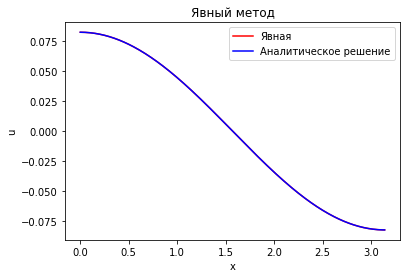

In [ ]:
index = int(np.floor(X.shape[0] / 2))

plt.title("Явный метод")
plt.plot(X[index], Z[index], label="Явная", color = "red")
plt.plot(X[index], ans[index], label="Аналитическое решение", color = "blue")
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

In [ ]:
def race_method(A, b):
    """
    Solves Ax=b
    """
    n = len(A)
    
    # Step 1. Forward
    v = [0 for _ in range(n)]
    u = [0 for _ in range(n)]
    v[0] = A[0][1] / -A[0][0]
    u[0] = b[0] / A[0][0]
    for i in range(1, n-1):
        v[i] = A[i][i+1] / (-A[i][i] - A[i][i-1] * v[i-1])
        u[i] = (A[i][i-1] * u[i-1] - b[i]) / (-A[i][i] - A[i][i-1] * v[i-1])
    v[n-1] = 0
    u[n-1] = (A[n-1][n-2] * u[n-2] - b[n-1]) / (-A[n-1][n-1] - A[n-1][n-2] * v[n-2])

    # Step 2. Backward
    x = [0 for _ in range(n)]
    x[n-1] = u[n-1]
    for i in range(n-1, 0, -1):
        x[i-1] = v[i-1] * x[i] + u[i-1]
    return np.array(x)

### Неявная конечно-разностная схема
В исходном уравнении перейдем от производных к их численным приближениям. Вторую производную будем аппроксимировать по значениям верхнего временного слоя.
Чтобы получить значения $u$ в одном временном ряду, необходимо решить систему уравнений:

В исходном уравнении перейдем от производных к их численным приближениям. Вторую производную будем аппроксимировать по значениям верхнего временного слоя.

Чтобы получить значения $u$ в одном временном ряду, необходимо решить систему уравнений:

$\large\begin{equation*}
 \begin{cases}
   b_1u_1^{k+1}+c_1u_2^{k+1}=d_1, ~~~j=1, 
   \\
   a_ju_{j-1}^{k+1}+b_ju_j^{k+1}+c_ju_{j+1}^{k+1}=d_j, ~~~j=2\dots N-2,
   \\
   a_{N-1}u_{N-2}^{k+1}+b_{N-1}u_{N-1}^{k+1}=d_{N-1}, ~~~j=N-1.
 \end{cases}
\end{equation*}$

$a_j=c_j=\sigma$

$b_j=-(1+2\sigma)$

$d_j = -u_j^k, ~~~j=2\dots N-2$

$d_1=-(u_1^k+\sigma\phi_0(t^{k+1}))$

$d_{N-1}=-(u_{N-1}^k+\sigma\phi_1(t^{k+1}))$


Это трехдиагональная СЛАУ, которую можно решить методом прогонки.

In [ ]:
def implicit(sigma, h, a=1.0, l0=0, l1=math.pi, max_T=1):
    tau = get_tau(sigma, h)
    x = np.arange(l0, l1, h)
    T = np.arange(0, max_T, tau)
    result = np.zeros((len(T), len(x)))
    
    for i in range(len(x)):
        result[0][i] = u_0(x[i])
    
    a, c = sigma, sigma
    b = -1 - 2 * sigma
    X = []
    Y = []
    Z = []
    X.append(x)
    Y.append([0.0 for _ in x])
    Z.append(result[0])
    for k in range(1, T.shape[0]):
        # make coeffs matrix for race method
        abc_matrix = np.zeros((len(x) - 2, len(x) - 2))
        abc_matrix[0][0] = b
        abc_matrix[0][1] = c
        for i in range(1, len(abc_matrix) - 1):
            abc_matrix[i][i - 1] = a
            abc_matrix[i][i] = b
            abc_matrix[i][i + 1] = c  
        abc_matrix[-1][-2] = a
        abc_matrix[-1][-1] = b
        
        # d - coeffs
        d = np.copy(-result[k - 1][1:-1])
        d[0]  -=  sigma * phi_0(T[k])
        d[-1] -=  sigma * phi_l(T[k])
        result[k][1:-1] = race_method(abc_matrix, d)
        result[k][0]  = phi_0(T[k])
        result[k][-1] = phi_l(T[k])
        X.append(x)
        Y.append([k for _ in x])
        Z.append(result[k])
    
    return np.array(X), np.array(Y), np.array(Z)

In [ ]:
h = 0.01
sigma = 0.45
X, Y, Z = implicit(sigma, h, max_T=5.0)

In [ ]:
X.shape, Y.shape, Z.shape

((111112, 315), (111112, 315), (111112, 315))

In [ ]:
h = 0.01
sigma = 0.45
ans = get_ans(sigma, h, max_T=5.0)

In [ ]:
(abs(Z - ans) > 1e-4).sum()

0

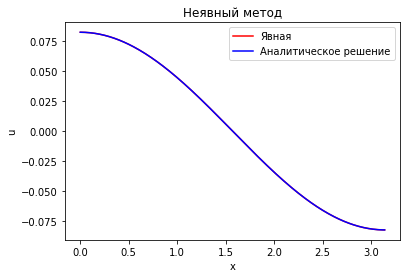

In [ ]:
index = int(np.floor(X.shape[0] / 2))
plt.title("Неявный метод")
plt.plot(X[index], Z[index], label="Явная", color = "red")
plt.plot(X[index], ans[index], label="Аналитическое решение", color = "blue")
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

### Схема Кранка-Николсона

Если визуализировать решения, полученные явной и неявной схемой, а также аналитическое решение, то можно заметить, что аналитическое решение часто лежит между двумя численными. Поэтому стоит попробовать использовать выпуклую комбинацию аппроксимаций второй производной (по верхнему и нижнему временному ряду).

Выпуклая комбинация - линейная комбинация, при которой коэффициенты неотрицательные и в сумме дают единицу. Будем использовать коэффициенты $\theta$ и $1-\theta$.

При $\theta = \frac{1}{2}$ имеем схему Кранка-Николсона.

Немного скорректируем систему уравнений из прошлой схемы

$\large\begin{equation*}
 \begin{cases}
   b_1u_1^{k+1}+c_1u_2^{k+1}=d_1, ~~~j=1, 
   \\
   a_ju_{j-1}^{k+1}+b_ju_j^{k+1}+c_ju_{j+1}^{k+1}=d_j, ~~~j=2\dots N-2,
   \\
   a_{N-1}u_{N-2}^{k+1}+b_{N-1}u_{N-1}^{k+1}=d_{N-1}, ~~~j=N-1.
 \end{cases}
\end{equation*}$

$a_j=c_j=\sigma\theta$

$b_j=-(1+2\sigma\theta)$

$d_j = -(u_j^k+(1-\theta)\sigma(u_{j-1}^k-2u_j^k+u_{j+1}^k)), ~~~j=2\dots N-2$

$d_1=-(u_1^k+\sigma\phi_0(t^{k+1}))$

$d_{N-1}=-(u_{N-1}^k+\sigma\phi_1(t^{k+1}))$


Это трехдиагональная СЛАУ, которую можно решить методом прогонки.

In [ ]:
def krank(sigma, h, a=1.0, l0=0, l1=math.pi, max_T=1, tetta=0.5):
    tau = get_tau(sigma, h)
    
    x = np.arange(l0, l1, h)
    T = np.arange(0, max_T, tau)
    result = np.zeros((len(T), len(x)))
    
    for i in range(len(x)):
        result[0][i] = u_0(x[i])
    
    a, c = sigma * tetta, sigma * tetta
    b = -1 - 2 * sigma * tetta
    
    X = []
    Y = []
    Z = []
    X.append(x)
    Y.append([0.0 for _ in x])
    Z.append(result[0])
    
    for k in range(1, T.shape[0]):
        # make coeffs matrix for race method
        abc_matrix = np.zeros((len(x) - 2, len(x) - 2))
        abc_matrix[0][0] = b
        abc_matrix[0][1] = c
        for i in range(1, len(abc_matrix) - 1):
            abc_matrix[i][i - 1] = a
            abc_matrix[i][i] = b
            abc_matrix[i][i + 1] = c  
        abc_matrix[-1][-2] = a
        abc_matrix[-1][-1] = b
        
        # d - coeffs
        d = np.zeros(len(x))
        for i in range(1, len(result[k - 1]) - 1):
            d[i] = np.array(-result[k - 1][i] - 
                      (1 - tetta) * sigma * (result[k - 1][i - 1] -
                            2 * result[k - 1][i] + result[k - 1][i + 1]))
        d = d[1 : -1]
        d[0]  -= sigma * tetta * phi_0(T[k])
        d[-1] -= sigma * tetta * phi_l(T[k])
        result[k][1:-1] = race_method(abc_matrix, d)
        result[k][0]  = phi_0(T[k])
        result[k][-1] = phi_l(T[k])
        X.append(x)
        Y.append([k for _ in x])
        Z.append(result[k])
    return np.array(X), np.array(Y), np.array(Z)

In [ ]:
h = .01
tau = .45
X, Y, Z = krank(sigma, h)

In [ ]:
h = .01
sigma = .45
ans = get_ans(sigma, h)

In [ ]:
X.shape, Y.shape, Z.shape

((20000, 315), (20000, 315), (20000, 315))

In [ ]:
(abs(Z - ans) > 1e-4).sum()

0

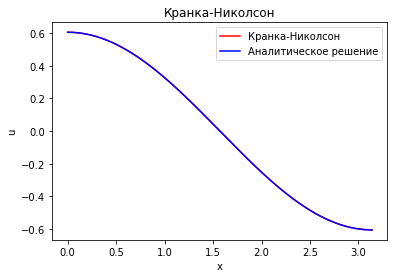

In [ ]:
index = int(np.floor(X.shape[0] / 2))

plt.title("Кранка-Николсон")
plt.plot(X[index], Z[index], label="Кранка-Николсон", color = "red")
plt.plot(X[index], ans[index], label="Аналитическое решение", color = "blue")
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

# Погрешность

In [ ]:
def error(Z, ans):
    return np.absolute(ans - Z).max(axis=1)

In [ ]:
def max_abs_error(A, B):
    """
    Calculate max absolute error of elements of matrices A and B
    """
    assert A.shape == B.shape
    return abs(A - B).max()

In [ ]:
def results(sigma, h, e, label, max_T=1.0):
    tau = get_tau(sigma, h)
    plt.figure(figsize=(15, 9))
    plt.title("Зависимость погрешности с течением времени")
    plt.plot(np.arange(0, max_T, tau), e, label=label, color = "red")
    plt.xlabel("t")
    plt.ylabel("error")
    plt.legend()
    plt.grid()

In [ ]:
h = 0.02
sigma = 0.5
X1, Y1, Z1 = explicit(sigma, h, max_T=5.0)
ans1 = get_ans(sigma, h, max_T=5.0)
e1 = error(Z1, ans1)

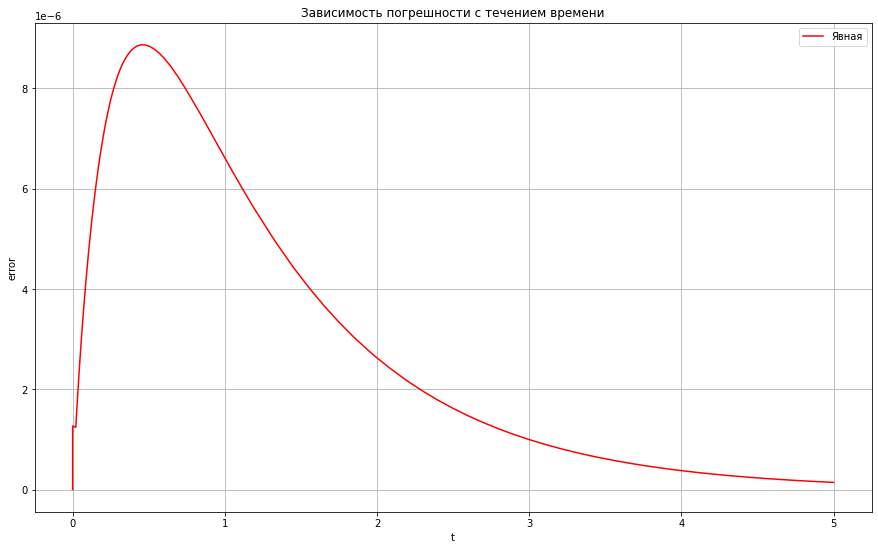

In [ ]:
results(sigma, h, e1, "Явная", max_T=5.0)

In [ ]:
h = 0.02
sigma = 0.5
X2, Y2, Z2 = implicit(sigma, h, max_T=5.0)
ans2 = get_ans(sigma, h, max_T=5.0)
e2 = error(Z2, ans2)

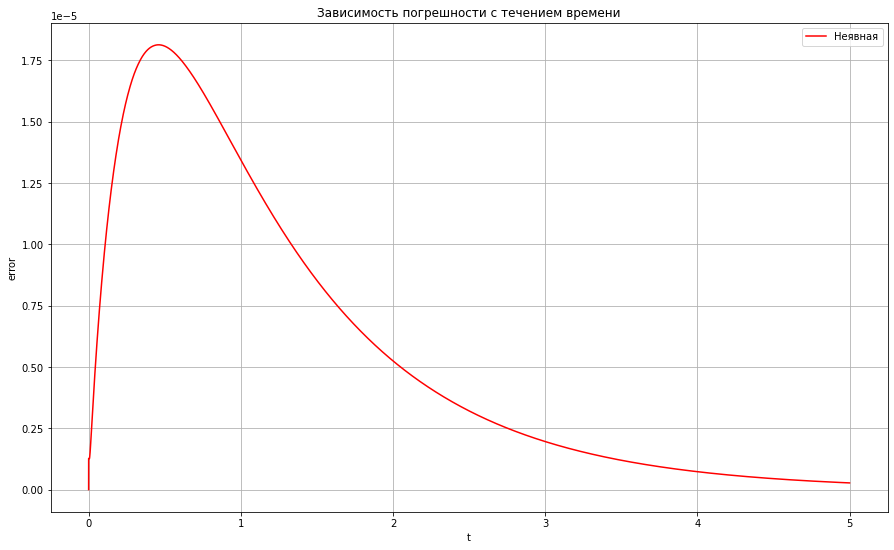

In [ ]:
results(sigma, h, e2, "Неявная", max_T=5.0)

In [ ]:
h = 0.02
sigma = 0.5
X3, Y3, Z3 = krank(sigma, h, max_T=5.0)
ans3 = get_ans(sigma, h, max_T=5.0)
e3 = error(Z3, ans3)

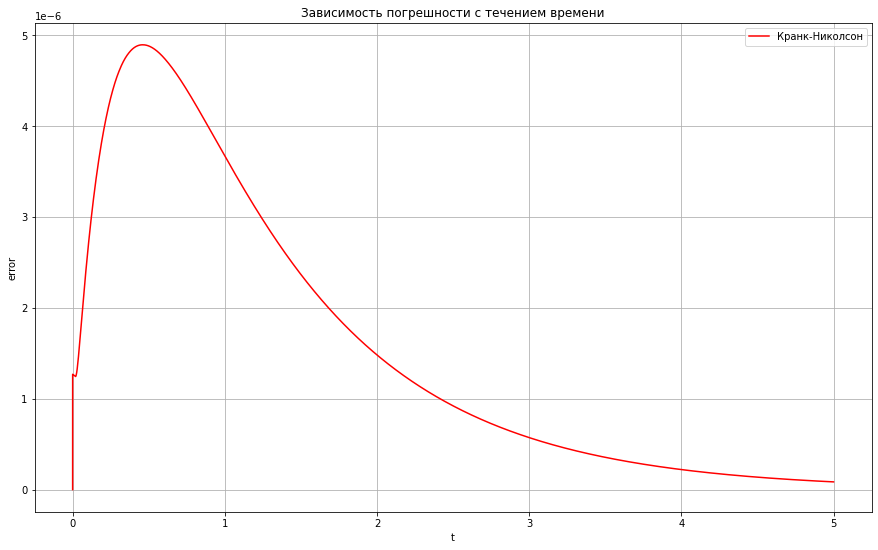

In [ ]:
results(sigma, h, e3, "Кранк-Николсон", max_T=5.0)

In [ ]:
def common_results(sigma, h, e1, e2, e3, max_T=1.0):
    tau = get_tau(sigma, h)
    plt.figure(figsize=(15, 9))
    plt.title("Зависимость погрешности с течением времени")
  
    plt.plot(np.arange(0, max_T, tau), e1, label="Явная", color = "red")
    plt.plot(np.arange(0, max_T, tau), e2, label="Неявная", color = "blue")
    plt.plot(np.arange(0, max_T, tau), e3, label="Кранк-Николсон", color = "green")
    
    plt.xlabel("t")
    plt.ylabel("error")
    plt.legend()
    plt.grid()

(25000,) (25000,) (25000,)


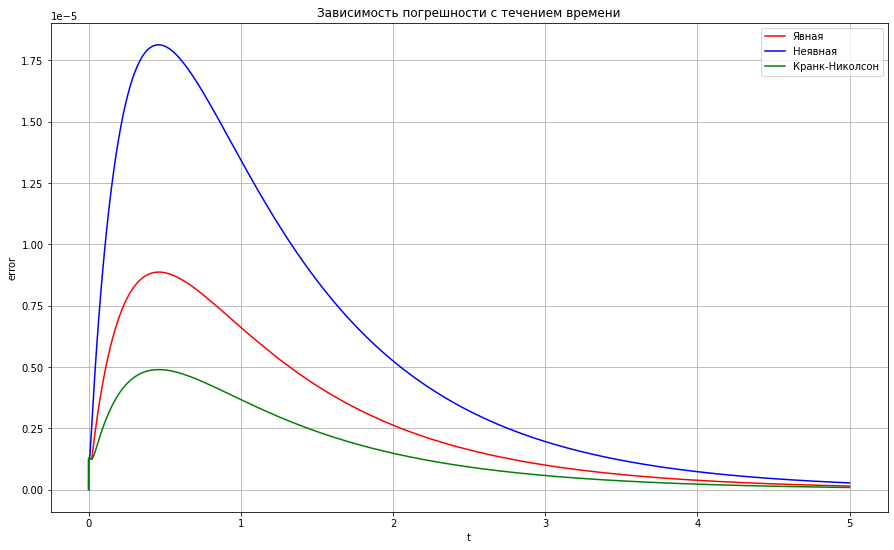

In [ ]:
h = 0.02
sigma = 0.5
print( e1.shape, e2.shape, e3.shape)
common_results(sigma, h, e1, e2, e3, max_T=5.0)

### Вывод

В данной лабораторной работе были решены начально-краевые задачи ДУ параболического типа. Для решение использовались явный метод, неявзынй метод, и метод Кранка-Николсона.

Явный вычисляется легко, но является нестабльным. Неявный метод является стабилным, но он более требовательный к вычислительным мощностям(вычисление матричных уравнений). Метод Кранка-Николсана является симбиозом меджу двумя методами.